# SWR CNN Autoencoder & Classification Pipeline

This notebook runs the complete SWR classification pipeline by importing and executing the main functions from the scripts in the `../cnn_autoencoder` directory.

**Workflow:**
1.  **Setup Paths:** Configure paths and set the main recording directory for inputs/outputs.
2.  **Step 1:** Generate spectrograms and extract biological features.
3.  **Step 2:** Train the CNN autoencoder (ResNet or VAE) on the spectrograms.
4.  **Step 3:** Cluster events using a combination of autoencoder and biological features.
5.  **Step 4:** Evaluate and visualize the final clusters.

In [1]:
import torch

# 1. Check if CUDA is available to PyTorch
print(f"CUDA Available: {torch.cuda.is_available()}")

# 2. Check the CUDA version PyTorch was compiled with
print(f"PyTorch CUDA Version: {torch.version.cuda}")

# 3. Check the cuDNN version PyTorch is using
print(f"cuDNN Version: {torch.backends.cudnn.version()}")

# 4. Get the name of your GPU
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

print("DEBUG: CuPy/CUDA status at script startup")
try:
    import cupy
    print("CuPy version:", cupy.__version__)
    print("CUDA runtime version:", cupy.cuda.runtime.runtimeGetVersion())
    print("CUDA driver version:", cupy.cuda.runtime.driverGetVersion())
    # print("GPU name:", cupy.cuda.runtime.getDeviceProperties(0)['name'].decode())
except Exception as e:
    print("CuPy/CUDA ERROR:", e)
print("="*60)

CUDA Available: True
PyTorch CUDA Version: 12.4
cuDNN Version: 90100
GPU Name: NVIDIA GeForce RTX 4070 SUPER
DEBUG: CuPy/CUDA status at script startup
CuPy version: 13.6.0
CUDA runtime version: 12090
CUDA driver version: 12060


In [3]:
import os
import sys

# --- 1. DEFINE PATHS & PARAMETERS ---

# !! IMPORTANT: This is the user-specified path for all outputs (and inputs)
recording_path = r"F:\Spikeinterface_practice"

# This is the root of the project (pfr_neurophys_data_analysis)
# Assumes this notebook is in pfr_neurophys_data_analysis/notebooks/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path to allow imports from cnn_autoencoder
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Change the current working directory to the recording path
# All generated files (models, plots, .pkl) will be saved here.
try:
    os.chdir(recording_path)
    print(f"Changed working directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"ERROR: Recording path not found: {recording_path}")
    print("Please update the 'recording_path' variable in this cell.")

print(f"Project root added to sys.path: {project_root}")

# --- 2. DEFINE PIPELINE PARAMETERS ---
# These can be adjusted as needed
ARCH = 'resnet'      # 'resnet', 'vae', or 'attention'
LATENT_DIM = 128     # Latent dimension for the autoencoder
EPOCHS = 15          # Number of epochs for training

Changed working directory to: F:\Spikeinterface_practice
Project root added to sys.path: F:\


#### Step 1: Generate Spectrograms and Extract Features

This step runs `generate_spectrograms.py`.
- Detects SWR events from the raw data.
- Generates spectrogram images for each event.
- Extracts biological features (duration, frequency, power, etc.).

**Output files (saved to recording_path):**
- `all_spectrograms/` (directory)

In [5]:
# Import your existing modules
import numpy as np
from open_ephys_loader import fast_openephys_dat_lfp
from spike_analysis import SpikeAnalysis, loader, process_spike_data, load_processed_spike_data
from swr_detection.swr_hmm_detection import SWRHMMParams, SWRHMMDetector
from swr_detection.pipeline import find_region_channels, build_region_lfp
from swr_detection.swr_spectral_features import batch_compute_spectral_features

# Import new feature extraction module
from cnn_autoencoder.feature_extraction import batch_extract_features, validate_biological_features
"""
Performs SWR detection, computes spectrograms, AND extracts biological features.
This creates a richer dataset for clustering.
"""
print("="*80)
print("IMPROVED SWR DETECTION WITH COMPREHENSIVE FEATURE EXTRACTION")
print("="*80)

# --- Configuration ---
dat_path = r"F:\Spikeinterface_practice\s4_rec\ephys.dat"
num_channels = 43
selected_channels = {
    'CA1_tet1': 17, 'CA1_tet2': 21, 'RTC_tet1': 14, 'PFC_tet1': 0, 'PFC_tet2': 5
}
fs_in = 30000.0
fs_out = 1000.0
# output_dir = "all_spectrograms"
output_dir = r"F:\Spikeinterface_practice\all_spectrograms"

# --- Load LFP and Spike Data ---
print("\n--- Loading Data ---")
try:
    loader = fast_openephys_dat_lfp(
        filepath=dat_path,
        num_channels=num_channels,
        tetrode_groups={},
        selected_channels=selected_channels,
        sampling_frequency=fs_in,
        target_sampling_frequency=fs_out,
        return_mode="loader",
    )
    fs = float(loader.sampling_frequency)
    t_lfp = loader.time_vector()
    print(f"✓ LFP duration: {loader.duration:.2f}s at {fs:.1f} Hz")

    # Load spike data
    npy_path = r'F:\Spikeinterface_practice\s4_rec\phyMS5'
    save_path = r'F:\Spikeinterface_practice\s4_rec'
    if not os.path.exists(os.path.join(save_path, 'units.npy')):
        print("Processing spike data...")
        process_spike_data(npy_path, save_path, samp_freq=30000)

    units_file = os.path.join(save_path, 'units.npy')
    processed_spike_data = load_processed_spike_data(units_file)

    spike_analysis = SpikeAnalysis(
        processed_data=processed_spike_data,
        sampling_rate=30000,
        duration=loader.duration
    )

    region_mapping = {7: 'CA1', 8: 'CA1', 6: 'RTC', 2: 'PFC', 3: 'PFC'}
    spike_analysis.assign_brain_regions(region_mapping)

    mua_by_region = spike_analysis.compute_mua_all_regions(t_lfp=t_lfp, kernel_width=0.01)
    mua_vec = mua_by_region['CA1']

    region_channels = find_region_channels(list(loader.selected_channels.keys()))
    region_lfp = build_region_lfp(loader, region_channels)
    lfp_array = region_lfp['CA1']
    
    print(f"✓ LFP shape: {lfp_array.shape}")
    print(f"✓ MUA vector length: {len(mua_vec)}")

except FileNotFoundError as e:
    print(f"\nERROR: Data files not found: {e}")
    print(f"Attempted to load LFP from: {dat_path}")
    print("Cannot proceed without data. Exiting.")
    import sys
    sys.exit(1)

# --- SWR Detection ---
print("\n--- Detecting SWRs ---")
ripple_th = 2.75
params = SWRHMMParams(
    ripple_band=(120, 250),
    threshold_multiplier=ripple_th,
    use_smoothing=True,
    smoothing_sigma=0.01,
    normalization_method='zscore',
    min_duration=0.025,
    max_duration=0.4,
    min_event_separation=0.07,
    merge_interval=0.07,
    trace_window=1.0,
    adaptive_classification=True,
    dbscan_eps=0.15,
    mua_threshold_multiplier=2.5,
    mua_min_duration=0.03,
    enable_mua=True,
    use_hmm_edge_detection=False,
    hmm_margin=0.1,
    use_global_hmm=False,
    global_hmm_fraction=0.1,
    hmm_states_ripple=2,
    hmm_states_mua=2,
    use_hysteresis=False,
    hysteresis_low_multiplier=0.75,
    hysteresis_confirmation_window=0.07
)

detector = SWRHMMDetector(
    lfp_data=lfp_array,
    fs=fs,
    mua_data=mua_vec,
    params=params
)

detector.detect_events(channels=[0], average_mode=False) # 'all' for all channels in the lfp_array
detector.classify_events_improved()

print(f"✓ Found {len(detector.swr_events)} events")

# --- Compute Spectrograms ---
print("\n--- Computing Spectrograms ---")
pre_ms = 100
post_ms = 100
for event in detector.swr_events:
    event['spec_method'] = 'cwt'     # if using optimized CWT in your batch fn
    # ensure metadata stored (batch_compute_spectral_features should also set this,
    # but set here to be explicit so feature extraction can validate)
    event['spec_pre_ms'] = pre_ms
    event['spec_post_ms'] = post_ms

lfp_channel = region_lfp['CA1'][0]
n_computed = batch_compute_spectral_features(
    detector, 
    lfp_channel, 
    fs,
    use_gpu='auto',
    gpu_batch_size='auto',
    use_optimized_cwt=True,
    n_workers=20,
    verbose=True,
    target_freq_bins=150,
    n_bins=100,
    smoothing_sigma=1.0,
    pre_ms=pre_ms,
    post_ms=post_ms
)
print(f"✓ Successfully computed {n_computed} spectrograms")

# Check for peak frequency bias
peak_freqs = []
for e in detector.swr_events:
    spec = e.get('spectrogram')
    freqs = e.get('spectrogram_freqs')
    if spec is not None and freqs is not None and spec.ndim == 2:
        # Find peak across all time bins
        power_avg = np.mean(spec, axis=1)
        peak_idx = np.argmax(power_avg)
        peak_freqs.append(freqs[peak_idx])

if peak_freqs:
    peak_freqs = np.array(peak_freqs)
    print(f"\n📊 Peak Frequency Statistics:")
    print(f"   Mean: {np.mean(peak_freqs):.1f} Hz")
    print(f"   Median: {np.median(peak_freqs):.1f} Hz")
    print(f"   Std: {np.std(peak_freqs):.1f} Hz")
    print(f"   Range: [{np.min(peak_freqs):.1f}, {np.max(peak_freqs):.1f}] Hz")
    
    # Expected ripple range: 125-250 Hz, peak around 150-180 Hz
    if np.mean(peak_freqs) < 125:
        print(f"   ⚠️ WARNING: Mean peak frequency is LOW ({np.mean(peak_freqs):.1f} Hz)")
        print(f"              Expected ripple range: 125-250 Hz")
    elif np.mean(peak_freqs) > 200:
        print(f"   ⚠️ WARNING: Mean peak frequency is HIGH ({np.mean(peak_freqs):.1f} Hz)")
    else:
        print(f"   ✅ Peak frequencies in expected ripple range (125-250 Hz)")

print("\n" + "=" * 60)

IMPROVED SWR DETECTION WITH COMPREHENSIVE FEATURE EXTRACTION

--- Loading Data ---
✓ LFP duration: 2993.56s at 1000.0 Hz
✓ LFP shape: (2, 2993562)
✓ MUA vector length: 2993562

--- Detecting SWRs ---

Initialized SWR detector with 2 channels and 2993.56 seconds of data

Current Detection Parameters:

Core Parameters:
Ripple band: (120, 250) Hz
Threshold multiplier: 2.75 SD
Hysteresis thresholding: Disabled
Duration limits: 0.025-0.4 s

Signal Processing:
Notch frequency: 60 Hz
Sharp wave band: Disabled Hz
Trace window: 1.0 s

Event Detection:
Duration std threshold: 0.1 SD
Minimum event separation: 0.07 s
Merge threshold: 0.8

Classification Parameters:
Single separation: 200 ms
Burst intervals: 70-200 ms
Merge interval: 70 ms

MUA Parameters:
MUA detection: Enabled
MUA threshold: 2.5 SD
MUA min duration: 30 ms

HMM Edge Detection:
Use HMM edge detection: False

Movement Filtering:
Velocity threshold: None cm/s

Data Information:
Number of channels: 2
Recording duration: 2993.56 s
Samp

#### Step 2 Extracting Features

**Output files (saved to recording_path):**
- `detected_events.pkl`
- `biological_features.pkl`

In [6]:
# Import required libraries
import numpy as np
import pickle
from PIL import Image
import importlib
import cnn_autoencoder.feature_extraction
importlib.reload(cnn_autoencoder.feature_extraction)
from cnn_autoencoder.feature_extraction import batch_extract_features, validate_biological_features

# --- Extract Biological Features ---
print("\n--- Extracting Biological Features ---")

# Set extension_ms parameter for feature extraction
extension_ms = 100  # <-- Set to desired value in ms (e.g., 20)

feature_matrix, feature_names = batch_extract_features(
    detector.swr_events,
    lfp_channel,
    mua_vec,
    fs,
    region_lfp=region_lfp,
    verbose=True,
    normalize_lfp=True,
    extension_ms=extension_ms,
    # <-- extension_ms now supported and propagated
    # Set extension_ms to extend all trace segments used for feature extraction
    # e.g., extension_ms=20 will add 20 ms before and after each event window
    # If unsure, leave as 0 for legacy behavior
)

print(f"✓ Extracted {feature_matrix.shape[1]} features from {feature_matrix.shape[0]} events")
print(f"\nFeature names: {feature_names}")

# Validate features
validate_biological_features(feature_matrix, feature_names)

# --- Save Spectrograms as Images ---
print("\n--- Saving Spectrograms ---")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

n_saved = 0
for i, event in enumerate(detector.swr_events):
    spectrogram = event.get('spectrogram')
    if spectrogram is not None and isinstance(spectrogram, np.ndarray):
        try:
            spec_min = spectrogram.min()
            spec_max = spectrogram.max()
            if spec_max > spec_min:
                spec_norm = (spectrogram - spec_min) / (spec_max - spec_min) * 255
            else:
                spec_norm = np.zeros_like(spectrogram)
            
            img = Image.fromarray(spec_norm.astype(np.uint8), 'L')
            img_path = os.path.join(output_dir, f"event_{i:05d}.png")
            img.save(img_path)
            n_saved += 1
        except Exception as e:
            if n_saved < 5:
                print(f"Could not save image for event {i}: {e}")

print(f"✓ Successfully saved {n_saved} images to '{output_dir}/'")

# --- Save Data ---
print("\n--- Saving Data ---")

# Save events
events_path = "detected_events.pkl"
with open(events_path, "wb") as f:
    pickle.dump(detector.swr_events, f)
print(f"✓ Saved events to '{os.path.join(os.getcwd(), events_path)}'")

# Save biological features
bio_features_path = "biological_features.pkl"
with open(bio_features_path, "wb") as f:
    pickle.dump({
        'feature_matrix': feature_matrix,
        'feature_names': feature_names
    }, f)
print(f"✓ Saved biological features to '{os.path.join(os.getcwd(), bio_features_path)}'")

# --- Summary Statistics ---
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Total events detected: {len(detector.swr_events)}")
print(f"Spectrograms saved: {n_saved}")
print(f"Biological features extracted: {feature_matrix.shape[1]}")
print(f"Total feature dimensions: {feature_matrix.shape}")
print("\nNext steps:")
print("  1. Train autoencoder: python train_autoencoder_improved.py")
print("  2. Cluster with combined features: python cluster_events_improved.py")
print("="*80 + "\n")


--- Extracting Biological Features ---
Extracting features: 0/1640...
Extracting features: 100/1640...
Extracting features: 200/1640...
Extracting features: 300/1640...
Extracting features: 400/1640...
Extracting features: 500/1640...
Extracting features: 600/1640...
Extracting features: 700/1640...
Extracting features: 800/1640...
Extracting features: 900/1640...
Extracting features: 1000/1640...
Extracting features: 1100/1640...
Extracting features: 1200/1640...
Extracting features: 1300/1640...
Extracting features: 1400/1640...
Extracting features: 1500/1640...
Extracting features: 1600/1640...
Extracted 51 features from 1640 events
✓ Extracted 51 features from 1640 events

Feature names: ['channel_correlation', 'duration', 'end_time', 'envelope_area', 'envelope_asymmetry', 'envelope_curvature', 'envelope_kurtosis', 'frequency_chirp', 'in_ripple_band', 'lfp_kurtosis', 'lfp_peak_to_peak', 'lfp_rms', 'lfp_skewness', 'lfp_std', 'max_channel_idx', 'mean_spatial_coherence', 'mua_integra

In [10]:
print("lfp_channel shape:", np.asarray(lfp_channel).shape)
print("region_lfp['CA1'] shape:", np.asarray(region_lfp['CA1']).shape)

lfp_channel shape: (2993562,)
region_lfp['CA1'] shape: (2, 2993562)


In [ ]:
import importlib
import cnn_autoencoder.feature_viz as fv

# when code changes:
importlib.reload(fv)

# call the function from the module
fv.visualize_features(feature_matrix, feature_names, events=detector.swr_events)

Output()

## Step 2: Train Autoencoder

This step runs `train_autoencoder.py`.
- Loads the spectrograms from `all_spectrograms/`.
- Trains the specified CNN autoencoder (`resnet` or `vae`).

**Output files (saved to recording_path):**
- `full_model_resnet.pkl` (or similar, based on arch)
- `encoder_model_resnet.pkl`
- `training_history_resnet.png`

In [10]:
print("\n" + "="*80)
print("STEP 2: TRAINING AUTOENCODER...")
print("="*80)

try:
    # Force reload to pick up changes to train_autoencoder.py
    import importlib
    import cnn_autoencoder.train_autoencoder
    importlib.reload(cnn_autoencoder.train_autoencoder)
    from cnn_autoencoder.train_autoencoder import train_autoencoder
    
    # Use parent directory where all_spectrograms is located
    # Current dir: F:\Spikeinterface_practice\s4_rec
    # Images dir:  F:\Spikeinterface_practice\all_spectrograms
    data_dir = os.path.dirname(output_dir)  # F:\Spikeinterface_practice
    cnn_files_dir = r'F:\Spikeinterface_practice\cnn_files'
    print(f"Looking for spectrograms in: {os.path.join(data_dir, 'all_spectrograms')}")
    
    train_autoencoder(
        arch=ARCH,
        latent_dim=LATENT_DIM,
        epochs=EPOCHS,
        lr=None,      # Use 'None' to trigger auto learning rate finder
        beta=1.0,     # Beta parameter for VAE (ignored for ResNet)
        data_dir=data_dir,  # Point to parent directory
        cnn_files_dir=cnn_files_dir  # <--- add this line
    )
    
    print("\n" + "-"*80)
    print("STEP 2 COMPLETE")
    print("-"*80)
except ImportError as e:
    print(f"ERROR: Could not import 'train_autoencoder'.")
    print(f"Ensure 'train_autoencoder.py' is in {os.path.join(project_root, 'cnn_autoencoder')}")
    print(f"Import error: {e}")
except Exception as e:
    print(f"An error occurred during Step 2: {e}")
    import traceback
    traceback.print_exc()


STEP 2: TRAINING AUTOENCODER...
Looking for spectrograms in: F:\Spikeinterface_practice\all_spectrograms
Device: cuda
Found 1640 images
Training resnet autoencoder with latent_dim=128
Total parameters: 7,362,977
Epoch 1/15  Loss: 0.071725
✓ Checkpoint saved: F:\Spikeinterface_practice\cnn_files\full_model_resnet.pth
Epoch 2/15  Loss: 0.015287
✓ Checkpoint saved: F:\Spikeinterface_practice\cnn_files\full_model_resnet.pth
Epoch 3/15  Loss: 0.010226
✓ Checkpoint saved: F:\Spikeinterface_practice\cnn_files\full_model_resnet.pth
Epoch 4/15  Loss: 0.007389
✓ Checkpoint saved: F:\Spikeinterface_practice\cnn_files\full_model_resnet.pth
Epoch 5/15  Loss: 0.005717
✓ Checkpoint saved: F:\Spikeinterface_practice\cnn_files\full_model_resnet.pth
Epoch 6/15  Loss: 0.004556
✓ Checkpoint saved: F:\Spikeinterface_practice\cnn_files\full_model_resnet.pth
Epoch 7/15  Loss: 0.003774
✓ Checkpoint saved: F:\Spikeinterface_practice\cnn_files\full_model_resnet.pth
Epoch 8/15  Loss: 0.003122
✓ Checkpoint saved

#### Step 3: Cluster Events (general)

This step runs `cluster_events.py`.
- Loads the trained encoder (`encoder_model_...pkl`).
- Loads the biological features (`biological_features.pkl`).
- Generates latent features from the autoencoder.
- Combines features and performs clustering to find optimal k.

**Output files (saved to recording_path):**
- `events_with_clusters_combined.pkl`
- `clustering_info_combined.pkl`
- `clustering_metrics_plot.png`
- `dendrogram.png`

In [12]:
import importlib
import cnn_autoencoder.train_autoencoder
importlib.reload(cnn_autoencoder.train_autoencoder)
from cnn_autoencoder.train_autoencoder import load_encoder, encode_spectrograms
encoder = load_encoder(os.path.join(cnn_files_dir, 'encoder_model_resnet.pkl'), arch=ARCH, latent_dim=LATENT_DIM)
latents = encode_spectrograms(encoder, image_dir=data_dir, n_events=feature_matrix.shape[0])
np.save(os.path.join(cnn_files_dir, 'latent_matrix.npy'), latents)

In [ ]:
# print("\n" + "="*80)
# print("STEP 3: CLUSTERING EVENTS...")
# print("="*80)

# try:
#     # Force reload to pick up changes to cluster_events.py
#     import importlib
#     import cnn_autoencoder.cluster_events
#     importlib.reload(cnn_autoencoder.cluster_events)
#     from cnn_autoencoder.cluster_events import cluster_events_improved

#     cluster_events_improved(
#         arch=ARCH,
#         latent_dim=LATENT_DIM,
#         k_range=range(2, 13),  # Test k from 2 to 12
#         ae_weight=0.7,
#         bio_weight=0.3,
#         use_combined=True    # <-- FIXED HERE
#     )

#     print("\n" + "-"*80)
#     print("STEP 3 COMPLETE")
#     print("-"*80)
# except ImportError as e:
#     print(f"ERROR: Could not import 'cluster_events_improved'.")
#     print(f"Ensure 'cluster_events.py' is in {os.path.join(project_root, 'cnn_autoencoder')}")
#     print(f"Import error: {e}")
# except Exception as e:
#     print(f"An error occurred during Step 3: {e}")
#     import traceback
#     traceback.print_exc()


STEP 3: CLUSTERING EVENTS...
IMPROVED CLUSTERING WITH COMBINED FEATURES

--- Loading Data ---
✓ Loaded 1640 events
Loading cached autoencoder features...
✓ Loaded 34 biological features

Combining features...
  Autoencoder features: (1640, 128)
  Biological features: (1640, 34)
  Weights: AE=70.0%, Bio=30.0%
✓ Combined feature shape: (1640, 162)

✓ Final feature matrix: (1640, 162)

--- Finding Optimal Number of Clusters ---
Testing k in range: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
IMPROVED CLUSTERING WITH COMBINED FEATURES

--- Loading Data ---
✓ Loaded 1640 events
Loading cached autoencoder features...
✓ Loaded 34 biological features

Combining features...
  Autoencoder features: (1640, 128)
  Biological features: (1640, 34)
  Weights: AE=70.0%, Bio=30.0%
✓ Combined feature shape: (1640, 162)

✓ Final feature matrix: (1640, 162)

--- Finding Optimal Number of Clusters ---
Testing k in range: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  k=2, kmeans: silhouette=0.058, DB=4.207, CH=88.7
  k=2

In [ ]:
# --- OPTIONAL: Advanced clustering backend (replace or run instead of cluster_events_improved) ---
import importlib
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import advanced_clustering utilities
import cnn_autoencoder.advanced_clustering as adv_clust
importlib.reload(adv_clust)
# expected functions: find_optimal_clusters, cross_validate_clustering, plot_clustering_metrics
# adapt names below if different in file

# 1) Load features produced earlier
# assume feature_matrix, feature_names are in notebook namespace (from batch_extract_features)
print("Feature matrix shape:", getattr(globals().get('feature_matrix'), 'shape', None))

# 2) Load / compute AE latents
# If you saved latent vectors during AE training, load them here; otherwise compute using your encoder.
# Example: try to load precomputed latents
latent_path = os.path.join(cnn_files_dir, 'latent_matrix.npy')
if os.path.exists(latent_path):
    latents = np.load(latent_path)  # shape (n_events, LATENT_DIM)
    print("Loaded latent matrix:", latents.shape)
else:
    # placeholder: compute latents from spectrogram images / encoder if available
    # from cnn_autoencoder.train_autoencoder import load_encoder, encode_spectrograms
    # encoder = load_encoder('encoder_model_resnet.pkl')
    # latents = encode_spectrograms(encoder, image_dir=..., n_events=feature_matrix.shape[0])
    raise RuntimeError(f"latent_matrix.npy not found; compute latents or save them to '{latent_path}'")

# 3) Prepare combined feature matrix (scale + optional PCA)
ae_weight = 0.7
bio_weight = 0.3

scaler_ae = StandardScaler().fit(latents)
scaler_bio = StandardScaler().fit(feature_matrix)

latents_s = scaler_ae.transform(latents) * ae_weight
bio_s = scaler_bio.transform(feature_matrix) * bio_weight

# optional PCA to reduce dimensionality before clustering for speed/stability
pca_dim = 50
if latents_s.shape[1] + bio_s.shape[1] > 200:
    pca = PCA(n_components=min(pca_dim, latents_s.shape[1]+bio_s.shape[1]-1), random_state=0)
    X = pca.fit_transform(np.hstack([latents_s, bio_s]))
    print("Reduced to PCA dims:", X.shape)
else:
    X = np.hstack([latents_s, bio_s])
    print("Combined feature matrix shape:", X.shape)

# 4) Run advanced search for optimal clustering
k_range = range(2, 13) 
methods = ['kmeans', 'gmm', 'agglomerative']  # adjust to functions implemented in advanced_clustering
best_config, results_df = adv_clust.find_optimal_clusters(X, k_range=k_range, methods=methods)
print("Best clustering:", best_config)

# 5) Stability check (optional)
ari_scores = adv_clust.cross_validate_clustering(X, n_clusters=int(best_config['k']), method=best_config['method'])
print("Stability ARI (median):", np.median(ari_scores))

# 6) Save outputs for downstream evaluation
with open('advanced_clustering_results.pkl', 'wb') as f:
    pickle.dump({'best': best_config, 'results_df': results_df, 'ari_scores': ari_scores}, f)
print("Saved advanced clustering results -> advanced_clustering_results.pkl")

# 7) Plot metrics (if function exists)
try:
    adv_clust.plot_clustering_metrics(results_df, outpath='clustering_metrics_advanced.png')
    print("Saved clustering metrics plot.")
except Exception:
    pass

# If you want to continue with evaluate_clusters, make sure to map labels back into detector.swr_events
# e.g. assign detector.swr_events[i]['cluster_advanced'] = labels[i] where labels are from best_config or results_df

Feature matrix shape: (1640, 54)
Loaded latent matrix: (1640, 128)
Combined feature matrix shape: (1640, 182)
Testing clustering configurations...

Testing k=2...
  K-Means: Sil=0.072, DB=4.162, CH=90.8
  GMM: Sil=0.061, DB=4.193, CH=91.6

Testing k=3...
  K-Means: Sil=0.050, DB=3.817, CH=76.7
  GMM: Sil=0.048, DB=3.917, CH=76.8

Testing k=4...
  K-Means: Sil=0.036, DB=3.788, CH=65.2
  GMM: Sil=0.034, DB=3.661, CH=71.9

Testing k=5...
  K-Means: Sil=0.016, DB=4.514, CH=49.4
  GMM: Sil=0.024, DB=3.829, CH=61.5

Testing k=6...
  K-Means: Sil=0.026, DB=4.384, CH=51.1
  GMM: Sil=0.034, DB=3.839, CH=53.5

Testing k=7...
  K-Means: Sil=0.016, DB=4.219, CH=46.2
  GMM: Sil=0.022, DB=3.833, CH=48.6

Testing k=8...
  K-Means: Sil=0.013, DB=4.182, CH=43.0
  GMM: Sil=0.017, DB=3.832, CH=44.3

Testing k=9...
  K-Means: Sil=0.010, DB=3.589, CH=37.3
  GMM: Sil=0.021, DB=3.967, CH=40.8

Testing k=10...
  K-Means: Sil=0.018, DB=4.207, CH=35.8
  GMM: Sil=0.011, DB=3.977, CH=36.9

Testing k=11...
  K-Mea

## Step 4: Evaluate and Validate Clusters

This step runs `evaluate_clusters.py`.
- Loads the clustered events (`events_with_clusters_combined.pkl`).
- Performs detailed biological validation.
- Generates summary plots and visualizations.

**Output files (saved to recording_path):**
- `feature_space_combined.png`
- `cluster_validation_report_combined.txt`
- `cluster_..._summary.png` (and other plots)


STEP 4: EVALUATING CLUSTERS...
COMPREHENSIVE CLUSTER EVALUATION

--- Loading Data ---
✓ Loaded 1640 clustered events
✓ Loaded clustering info
  Method: gmm
  k: 2
  Silhouette: 0.061

--- Preparing Data ---
✓ Found 2 clusters

PART 1: BIOLOGICAL VALIDATION

BIOLOGICAL VALIDATION REPORT

──────────────────────────────────────────────────────────────────────
CLUSTER 0 (n=672 events)
──────────────────────────────────────────────────────────────────────

1. Duration Analysis:
   Mean: 56.3 ms
   Std:  36.3 ms
   CV:   0.645
   Range: 25.0 - 298.0 ms
   In expected range (15-500ms): 100.0%
   ⚠️  High variability - heterogeneous durations

2. Ripple Frequency Analysis:
   Mean peak frequency: 157.8 Hz
   Std: 17.0 Hz
   In ripple band (125-250 Hz): 98.8%
   ✓ Excellent - most events in canonical ripple band

4. Ripple Power:
   Mean: 1.607
   Std:  1.996

5. Inter-Event Intervals:
   Median: 2.091 s
   Mean:   4.426 s
   Min:    95.0 ms
   IEIs < 100ms: 0.1%

7. Quality Assessment:
   ✓ D

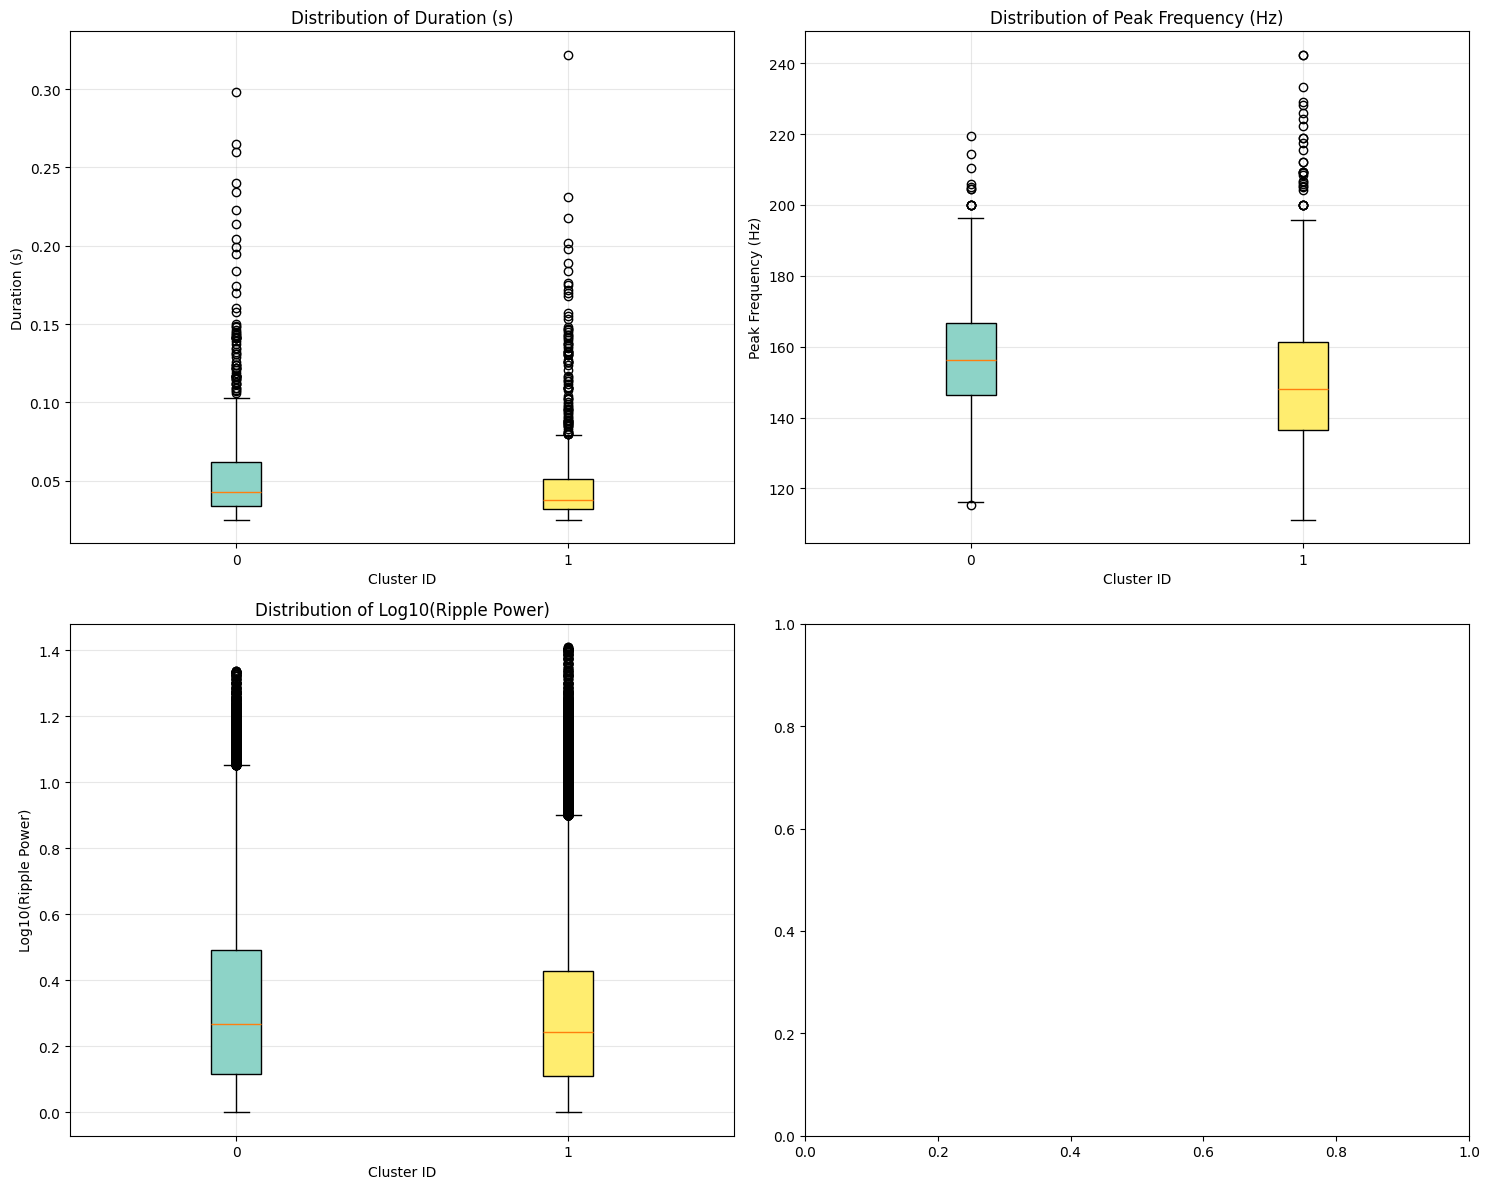

✓ Saved summary plot to 'cluster_combined_summary.png'


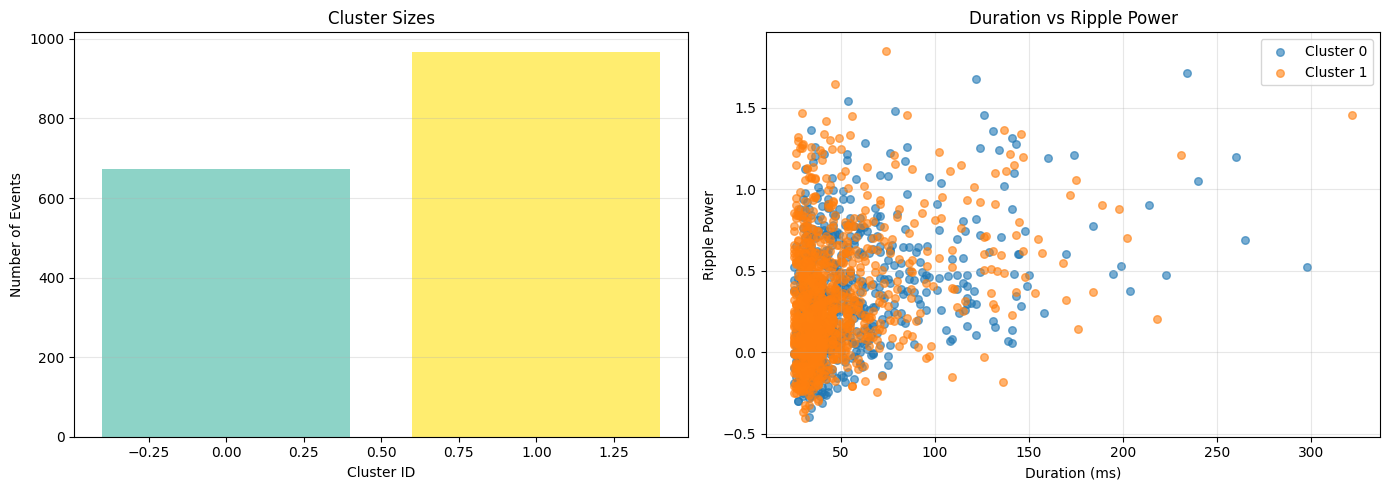


3.2: Visualizing feature space...
  Computing t-SNE (may take a moment)...
✓ Saved feature space plot to 'feature_space_combined.png'


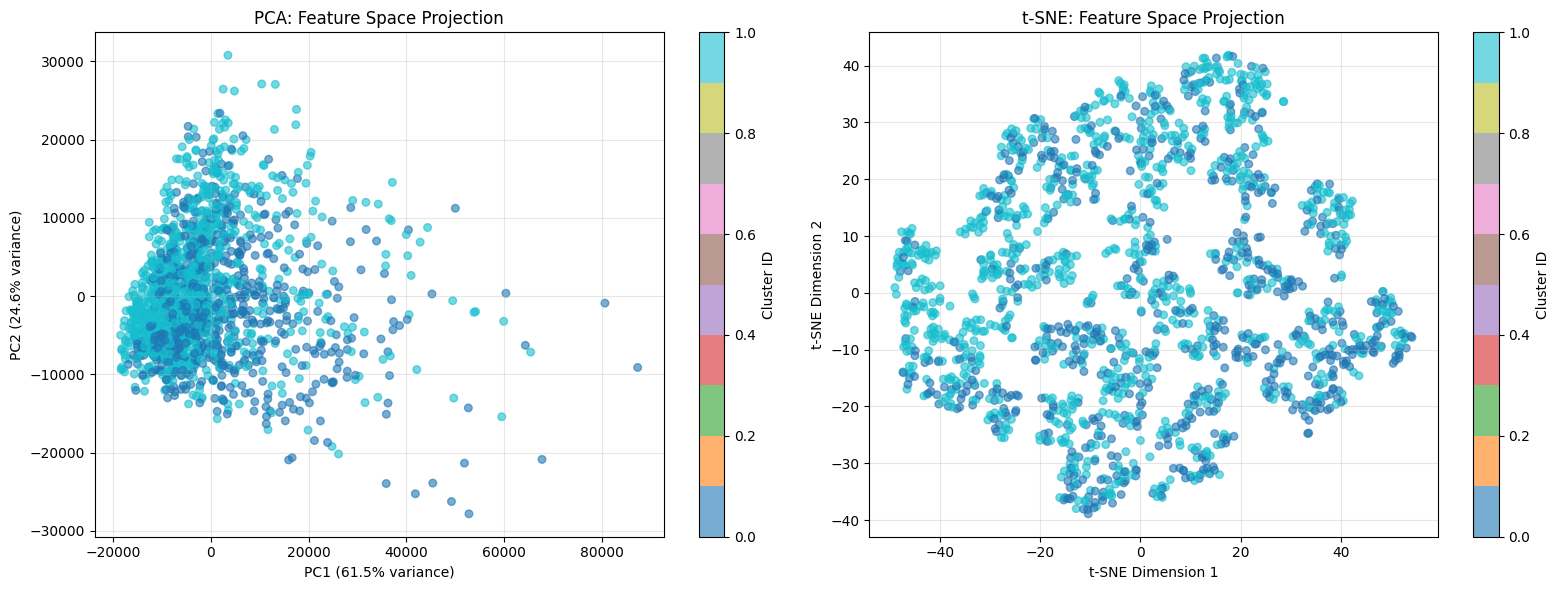


3.3: Computing average spectrograms per cluster...
  ✓ Saved average spectrogram for cluster 0


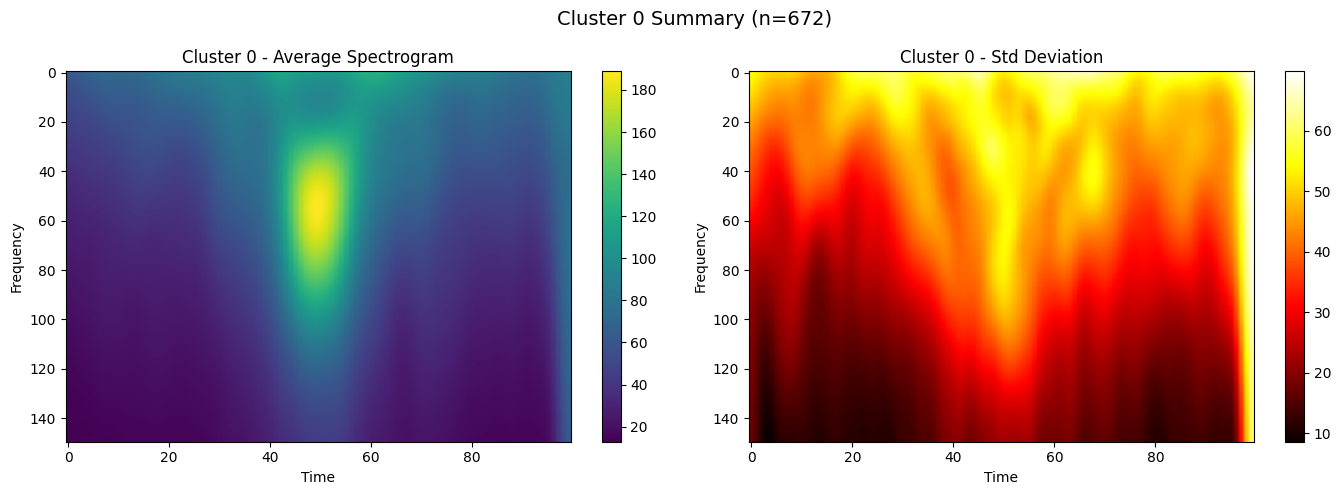

  ✓ Saved average spectrogram for cluster 1


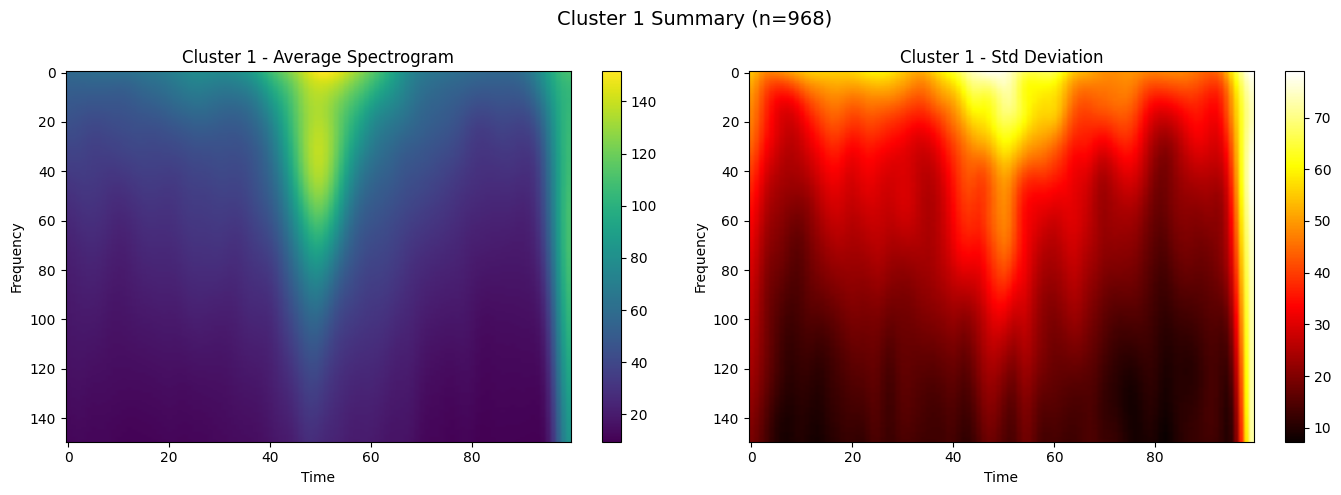


3.4: Showing sample images from each cluster...
  ✓ Saved samples for cluster 0


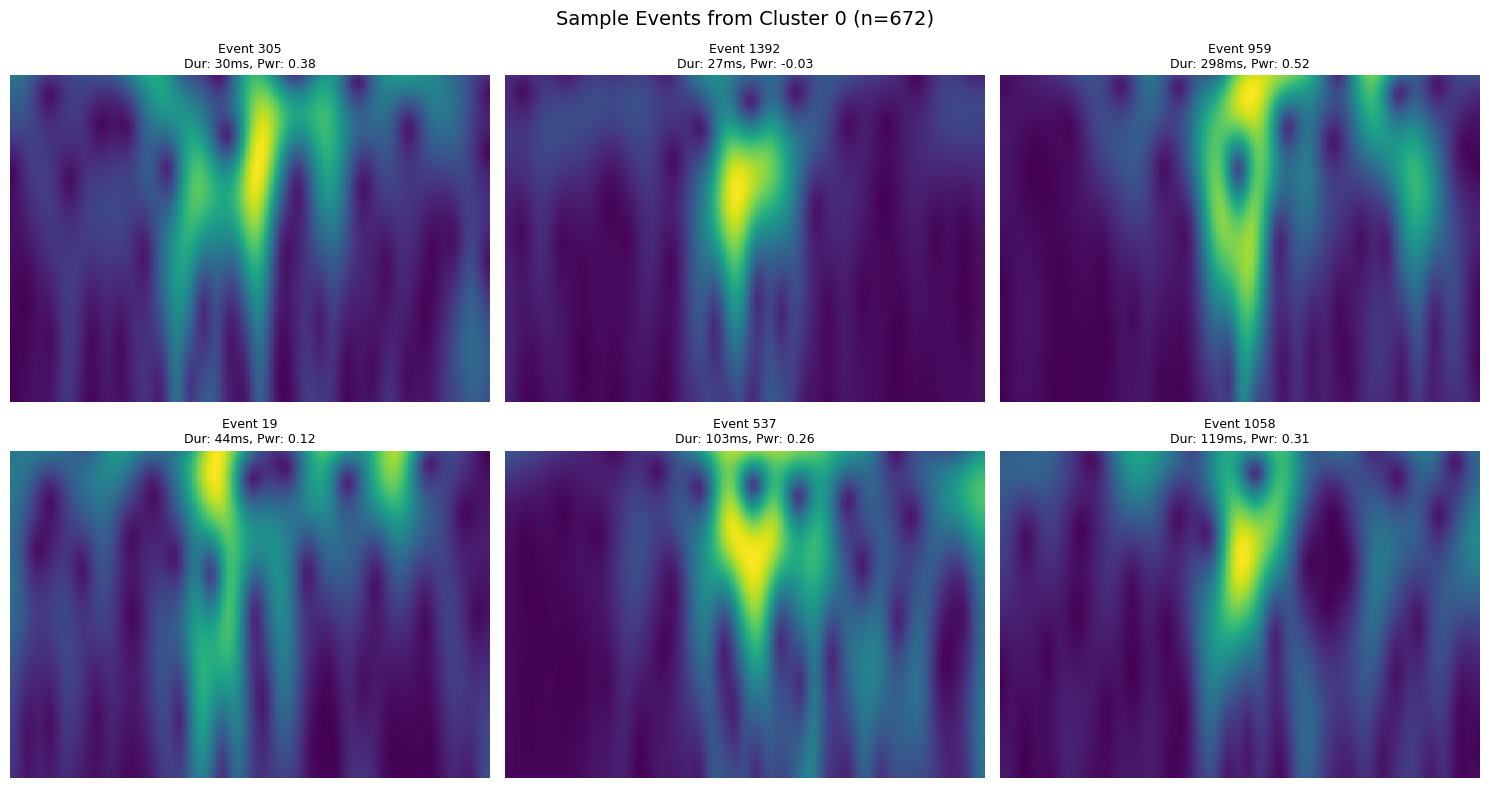

  ✓ Saved samples for cluster 1


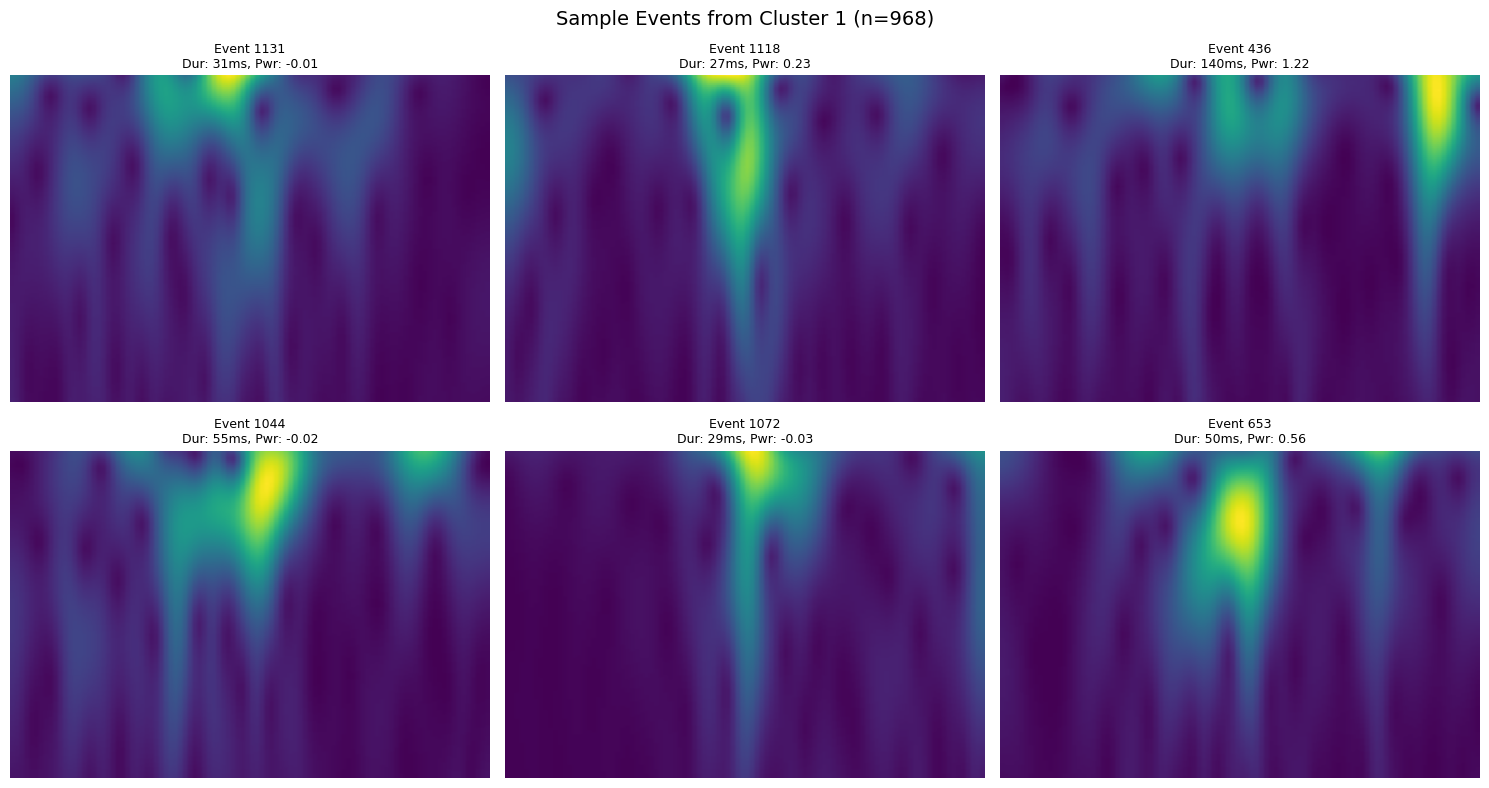


--- Exporting Report ---
✓ Exported validation report to 'cluster_validation_report_combined.txt'

EVALUATION COMPLETE

Cluster quality summary:
  cluster_0: 100% ✓✓ Excellent
  cluster_1: 100% ✓✓ Excellent

Generated files:
  - feature_space_combined.png
  - cluster_*_characteristics_boxplots.png
  - cluster_*_summary.png
  - cluster_0_avg_spectrogram.png
  - cluster_0_samples.png
  - cluster_1_avg_spectrogram.png
  - cluster_1_samples.png
  - cluster_validation_report_combined.txt



PIPELINE FINISHED!
All outputs saved to: F:\Spikeinterface_practice\s4_rec


In [14]:
import importlib
import cnn_autoencoder.evaluate_clusters
importlib.reload(cnn_autoencoder.evaluate_clusters)
from cnn_autoencoder.evaluate_clusters import evaluate_clusters_improved  # noqa: E402

print("\n" + "="*80)
print("STEP 4: EVALUATING CLUSTERS...")
print("="*80)

try:
    # Imports from pfr_neurophys_data_analysis/cnn_autoencoder/evaluate_clusters.py
    import importlib
    import cnn_autoencoder.evaluate_clusters
    importlib.reload(cnn_autoencoder.evaluate_clusters)
    from cnn_autoencoder.evaluate_clusters import evaluate_clusters_improved
    
    # Use 'combined' since we clustered with combined features in Step 3
    evaluate_clusters_improved(feature_type='combined')
    
    print("\n" + "="*80)
    print("PIPELINE FINISHED!")
    print(f"All outputs saved to: {os.getcwd()}")
    print("="*80)
except ImportError as e:
    print("ERROR: Could not import 'evaluate_clusters_improved'.")
    print(f"Ensure 'evaluate_clusters.py' is in {os.path.join(project_root, 'cnn_autoencoder')}")
    print(f"Import error: {e}")
except Exception as e:
    print(f"An error occurred during Step 4: {e}")
    import traceback
    traceback.print_exc()

In [15]:
# get labels (try several common locations)
if 'results_df' in globals() and 'labels' in results_df.columns:
    labels = results_df['labels'].astype(int).values
elif isinstance(best_config, dict) and 'labels' in best_config:
    labels = np.asarray(best_config['labels']).astype(int)
else:
    # fallback: ask fitted model to predict
    model = best_config.get('model') if isinstance(best_config, dict) else None
    if model is not None and hasattr(model, 'predict'):
        labels = model.predict(X).astype(int)
    else:
        raise RuntimeError("Could not locate labels. Inspect results_df, best_config or model.")

# sanity check
if len(labels) != len(detector.swr_events):
    raise RuntimeError(f"Label count ({len(labels)}) != number of events ({len(detector.swr_events)}). Ensure same ordering.")

# map labels back into events
for i, (evt, lab) in enumerate(zip(detector.swr_events, labels)):
    evt['cluster_advanced'] = int(lab)
    evt['cluster_method'] = best_config.get('method') if isinstance(best_config, dict) else None
    evt['cluster_k'] = int(best_config.get('k')) if isinstance(best_config, dict) and best_config.get('k') is not None else None

# optional: add per-event cluster probabilities if using GMM
model = best_config.get('model') if isinstance(best_config, dict) else None
if model is not None and hasattr(model, 'predict_proba'):
    probs = model.predict_proba(X)
    for i, evt in enumerate(detector.swr_events):
        evt['cluster_probs'] = probs[i].tolist()

# save updated events
import pickle
out_path = "events_with_clusters_advanced.pkl"
with open(out_path, "wb") as f:
    pickle.dump(detector.swr_events, f)
print(f"Saved events with cluster labels -> {out_path}")

ValueError: setting an array element with a sequence.